In [1]:
import pylab
import h5py
import math
import array
import gwnr
import gwnr.waveform.enigma_utils as eu
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
import pycbc.conversions as convert

import lal
import lalsimulation as ls

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker


plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=15) 
#pylab.rc('ytick', labelsize=15) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)

In [2]:
%run Model_22_Updated.ipynb

In [3]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion

#%run GW_functions.ipynb 
#%run Match_Functions_Circular.ipynb

print(A)
print(B)
print(C)

In [4]:
xconv(20,110)
fconv(xconv(20,110),150)

14.666666666666671

### call hybrids except 1360,1361,1370 using the current Hinder+inspired model

In [5]:
sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=20, mass2=20, delta_t=1/2048, f_lower=20)

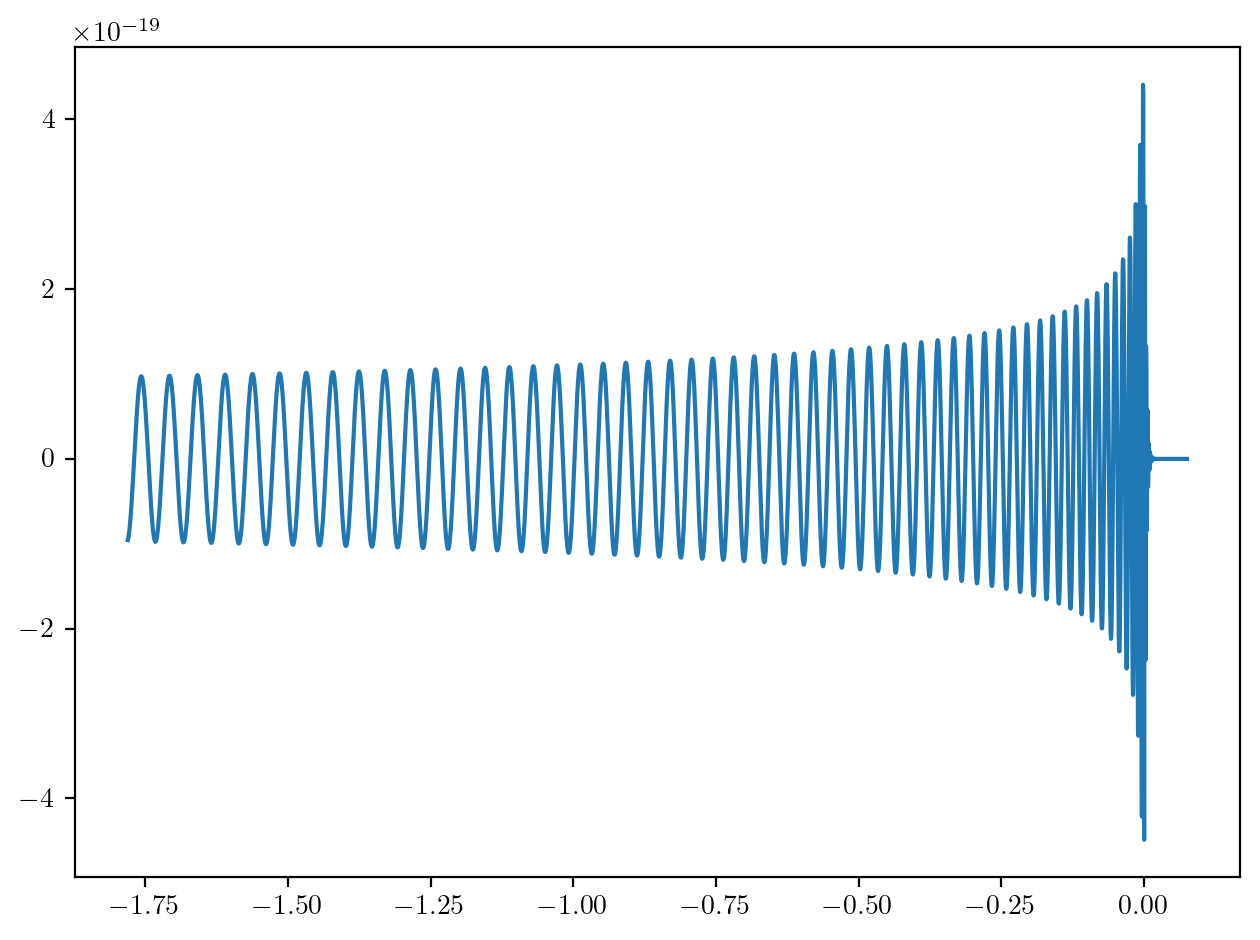

In [6]:
plt.plot(sp.sample_times,sp)

In [7]:
q0 = 2.5138099999999999
Mass_total=200
Mass1 = convert.mass1_from_mtotal_q(Mass_total,q0)
Mass2 = convert.mass2_from_mtotal_q(Mass_total,q0)
print(Mass1)
sample_rate = 4096
s1z = 0
s2z = 0
e0 = 0.2#17724600000000001
l0 = -1.5274109322488216
dt = 1./sample_rate
iota = 0
modes_to_use = [(2,2)]
distance = 1
M_SI = Mass_total*MSUN_SI
D_SI=(10**(6))*PC_SI
mode2polfac=4*(5/(64*np.pi))**(1/2)
fref = fconv(0.045,Mass_total)
print(0.055/PI)
hpl, hcr = eu.get_imr_enigma_waveform(Mass1, Mass2, fref, sample_rate, s1z, s2z, e0, l0, iota, 0, 
                                          distance,modes_to_use=modes_to_use)

143.0817261035742
0.01750704374010849


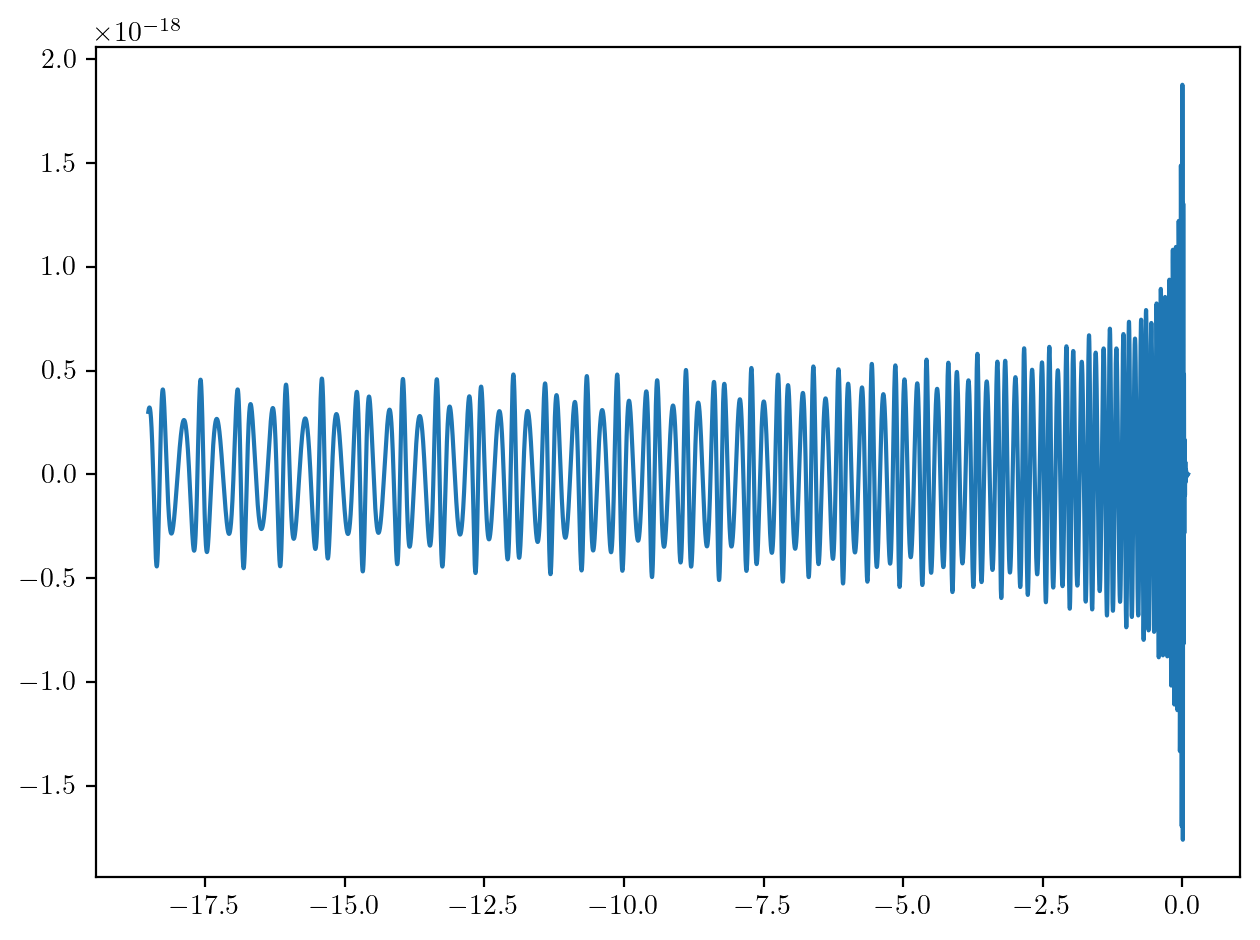

In [8]:
plt.plot(hpl.sample_times,hpl)


In [9]:
#Mtot = np.linspace(35,145,12)
Mtot = np.linspace(35,200,34)
print(Mtot)
#match1368 = []

[ 35.  40.  45.  50.  55.  60.  65.  70.  75.  80.  85.  90.  95. 100.
 105. 110. 115. 120. 125. 130. 135. 140. 145. 150. 155. 160. 165. 170.
 175. 180. 185. 190. 195. 200.]


In [10]:
def enigma_gen(M,q,e0,l0,fref,delta_t):
    
    mass_1 = convert.mass1_from_mtotal_q(M,q)
    mass_2 = convert.mass2_from_mtotal_q(M,q)
    dL = 1
    s1z = s2z = 0
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    iota = 0
    modes_to_use = [(2,2),(2,-2)]
    sample_rate = 4096
    distance = 1
    hp_en, hc_en = eu.get_imr_enigma_waveform(mass_1, mass_2, fref, sample_rate, s1z, s2z, e0, l0, iota, 0, 
                                          distance,
                                          modes_to_use=modes_to_use)
    
    time_en = hp_en.sample_times 
    
    #hp_en_new = hp_en / (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    #hc_en_new = hc_en / (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    
    return hp_en*mode2polfac, hc_en*mode2polfac, time_en

In [11]:
Mass = 35
fmin = fconv(0.03,Mass)
print(fmin)
fref = fconv(0.075,Mass)
delta_t = 1/4096
hp_enigma, hc_enigma, t_enigma = enigma_gen(Mass,2,0.2,-0.181,fmin,delta_t)
#hp_enigma, hc_enigma, t_enigma = enigma_gen(110,60/50,0.4,10,30,delta_t)
hp_model, hc_model,_ = model_22(Mass,2,0.15,-0.181,fmin,0,1,delta_t)

9.594325310323734


0.9345824593204581


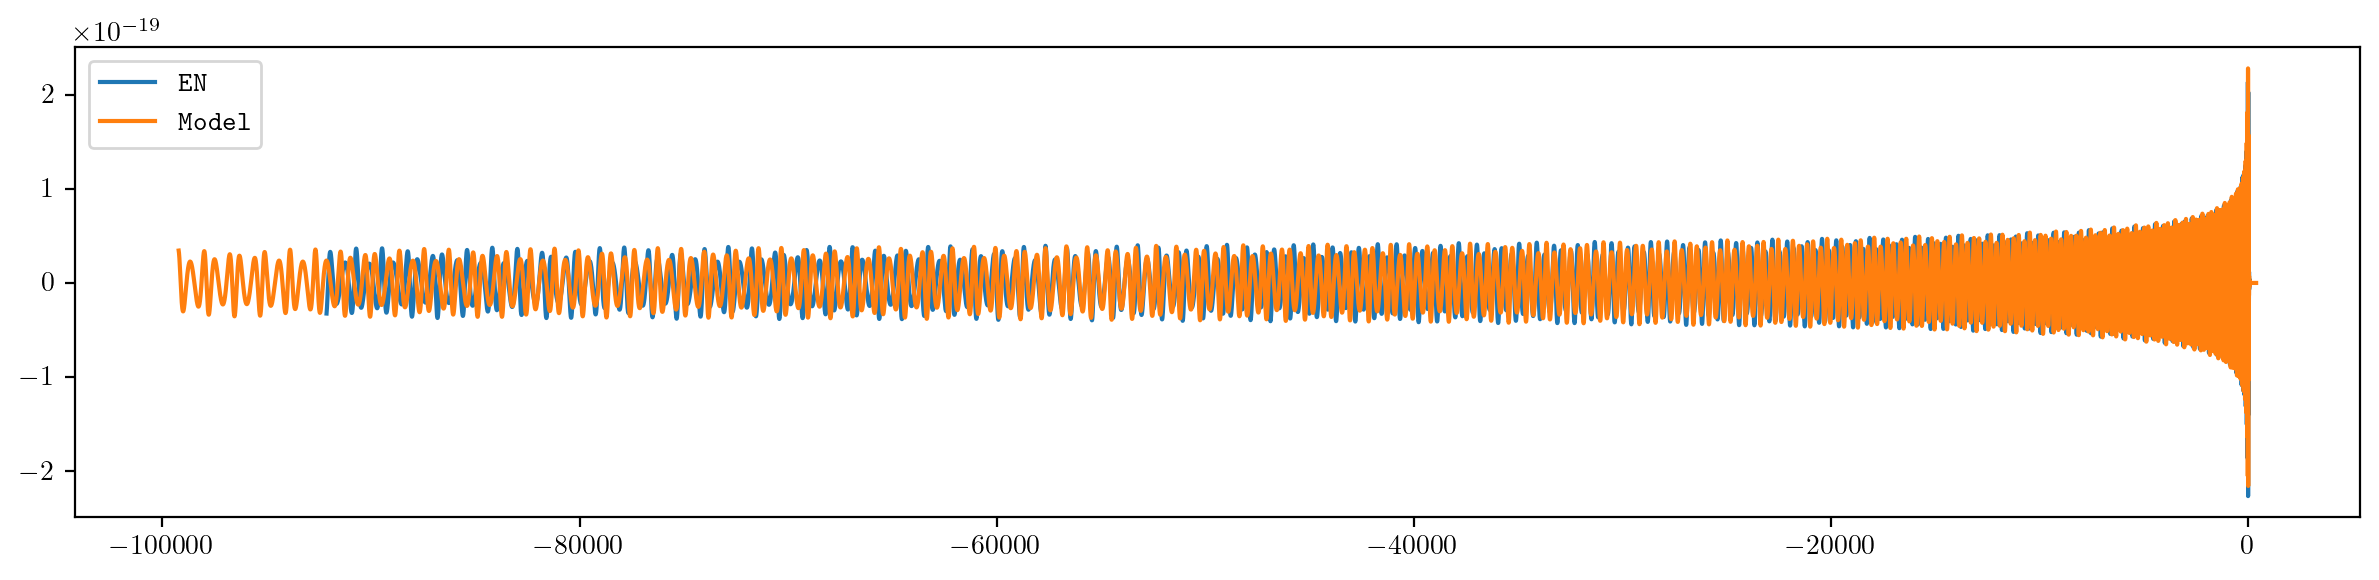

In [12]:
Abs_model = abs(hp_model-1j*hc_model)
t_model = hp_model.sample_times - (hp_model.sample_times)[np.argmax(Abs_model)]
plt.figure(figsize=(12,3))
plt.plot(t_enigma/(Mass*MTSUN_SI), hp_enigma,label = 'EN') #abs(hp_enigma+1j*hc_enigma))
plt.plot(t_model/(Mass*MTSUN_SI), hp_model,label='Model') #abs(hp_model+1j*hc_model))
#plt.plot(t_enigma,hp_enigma)
#plt.plot(hp_model.sample_times,hp_model)
#plt.xlim(xmin=2.5)
plt.legend()

hp_en_TS = TimeSeries(hp_enigma,delta_t)
tlen=max(len(hp_model),len(hp_en_TS))
hp_model.resize(tlen)
hp_en_TS.resize(tlen)
delta_f = 1.0 / hp_model.duration
flen = tlen//2 + 1
f_low = 20
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
m, i = match(hp_model, hp_en_TS, psd=psd, low_frequency_cutoff=f_low)
print(m)

In [13]:
%run Model_22_Updated.ipynb #have this file in the same loaction as the match code file

In [14]:
def MatchEnigma(q,e,l,delta_t):
    match_val = []
    for M in tqdm(Mtot):
        angle=0
        distance=1
        fmin = fconv(0.030,M)
        fref = fconv(0.075,M)
        #print(M,q,e,l,fmin,angle,distance,delta_t)
        hp_model, hc_model,_ = model_22(M,q,e,l,fmin,angle,distance,delta_t)
        hp_enigma, hc_enigma, t_enigma = enigma_gen(M,q,e,l,fmin,delta_t)
        hp_en_TS = TimeSeries(hp_enigma,delta_t)
        tlen=max(len(hp_model),len(hp_en_TS))
        hp_model.resize(tlen)
        hp_en_TS.resize(tlen)
        delta_f = 1.0 / hp_model.duration
        flen = tlen//2 + 1
        f_low = 20
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        m, i = match(hp_model, hp_en_TS, psd=psd, low_frequency_cutoff=f_low)
        match_val.append(m)
    return match_val

In [15]:
def MatchCirc(q,e,l,delta_t):
    match_val = []
    for M in tqdm(Mtot):
        fmin = fconv(0.030,M)
        fref = fconv(0.075,M)
        M1 = q/(1+q)*M
        M2 = 1/(1+q)*M
        #hp_model, hc_model = model_22(M,q,e,l,fmin,fref,delta_t)
        hp_enigma, hc_enigma, t_enigma = enigma_gen(M,q,e,l,fmin,delta_t)
        hp_en_TS = TimeSeries(hp_enigma,delta_t)
        hp_eob, hc_eob = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, mean_per_ano=l)
        tlen=max(len(hp_en_TS),len(hp_eob))
        hp_en_TS.resize(tlen)
        hp_eob.resize(tlen)
        delta_f = 1.0 / hp_en_TS.duration
        flen = tlen//2 + 1
        f_low = 20
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        m, i = match(hp_en_TS, hp_eob, psd=psd, low_frequency_cutoff=f_low)
        match_val.append(m)
    return match_val

In [16]:
#this was generated
g=open('/home/pratul/GW_Notebooks/Files/physical_data_10kpts_new.txt',"r") 
lines=g.readlines() 
q=[] 
eta = []
e_ini = []
l_ini = []
for x in lines: 
    if x.startswith("#"):
        continue
    q.append(float(x.split()[0])) 
    eta.append(float(x.split()[1])) 
    e_ini.append(float(x.split()[2])) 
    l_ini.append(float(x.split()[3])) 
g.close()

q = [2.795, 1.602, 2.038, 1.548, 2.765, 2.924, 1.389, 2.061, 1.781, 2.006, 1.929, 2.246, 1.047]
eta = [0.19407, 0.236618, 0.220815, 0.238436, 0.195059, 0.189898, 0.243372, 0.219964, 0.230283, 0.222, 0.22485, 0.213163, 0.249868]
e_ini = [0.1895, 0.0702, 0.1138, 0.0648, 0.1865, 0.168, 0.1161, 0.1076, 0.1106, 0.1609, 0.1346, 0.1525, 0.1652]
l_ini = [5.63916, 1.89124, 3.26097, 1.72159, 5.54491, 6.04442, 1.22208, 3.33323, 2.45358, 3.16044, 2.91854, 3.91442, 0.147655]

print(q)
print(eta)
print(e_ini)
print(l_ini)

[2565, 1832, 6285, 298, 6665, 8728, 4710, 1821, 4320, 3488, 47, 5585, 8877, 5410, 5326, 3304, 8352, 3733, 8806, 3703, 1842, 1175, 2444, 534, 2856]

set1=[2689, 8511, 4949, 2663, 9024, 2113, 4155, 5480, 1966, 4163, 6980, 4117, 6353, 3947, 5621, 2760, 1912, 8664, 8448, 2089, 6093, 7826, 6329, 7599, 8813]

In [17]:
set2 = [2750, 3944, 1617, 1264, 6004, 1183, 2910, 3041, 8405, 6745, 1527, 6497, 8453, 2173, 2728, 1489, 3886, 3144, 1814, 6154, 4554, 2076, 4885, 1624, 109]
randomlist = set2

In [18]:
import random
random.seed(40)
randomlist = random.sample(range(0, len(q)), 25)
print(randomlist)

[1878, 2373, 2146, 130, 1004, 1156, 2722, 2609, 2721, 845, 525, 3121, 1427, 1135, 3044, 1805, 117, 2160, 3017, 531, 242, 2626, 827, 2537, 2896]


for i in q:
    print(i/(1+i)**2)

In [19]:
#print(match_Enigma[0])

In [20]:
#pltbnd = np.where(np.array(q)>2)
print(len(q))

3195


print(pltbnd)

In [21]:
q = np.array(q)
eta = np.array(eta)
e_ini = np.array(e_ini)
l_ini = np.array(l_ini)

q = q[randomlist]
eta = eta[randomlist]
e_ini = e_ini[randomlist]
l_ini = l_ini[randomlist]

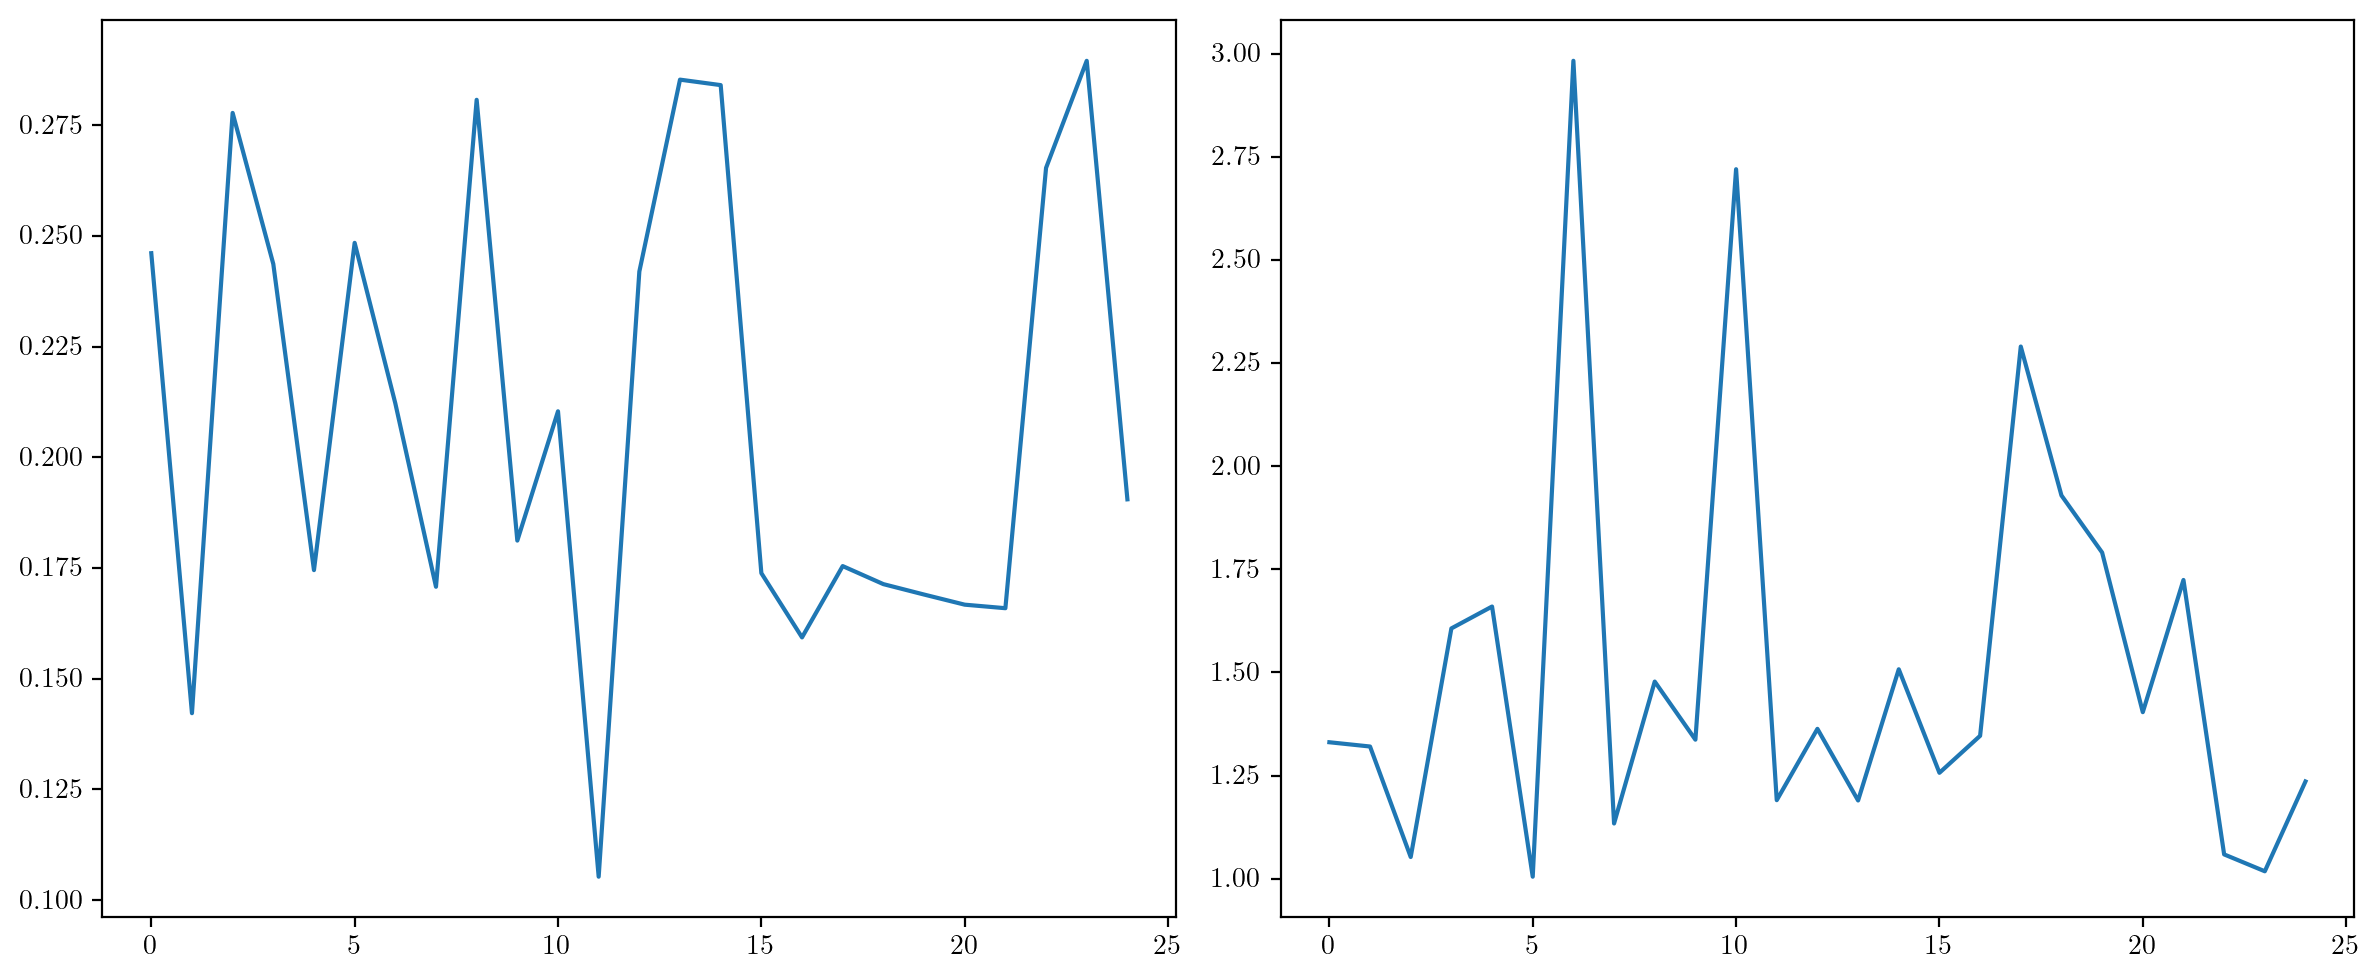

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(e_ini)
plt.subplot(1,2,2)
plt.plot(q)

print(q)
print(eta)
print(e_ini)
print(l_ini)

In [23]:
print(min(e_ini),max(e_ini))

0.105296 0.289517


In [24]:
match_Enigma1 = []
for k in range(0,len(q)):
    q_val = q[k]
    eta_val = eta[k]
    l_val = l_ini[k]
    e_val = e_ini[k]
    delta_t = 1./4096
    ##if l_ini[k]>PI:
        ##continue
    ##globals()['match' + str(k) + '_EN'] = MatchEnigma(q_val,e_val,l_val,delta_t)
    #print(q_val,e_val,l_val,delta_t)
    match_Enigma1.append(MatchEnigma(q_val,e_val,l_val,delta_t))

100%|███████████████████████████████████████████| 34/34 [02:38<00:00,  4.66s/it]


In [25]:
print(Mtot[31])#len(Mtot)
print(fconv(0.030,96.212))

190.0
3.4902235257694536


In [55]:
#print(e_ini)

print(match_Enigma1[24])

[0.9584625214566489, 0.9703664640345858, 0.9754515628701232, 0.9779110383118657, 0.9827865186297484, 0.9854277589656005, 0.9899469739499597, 0.9912510220406641, 0.9939339049484817, 0.9941374027958979, 0.9960941664679893, 0.9965551356907658, 0.9970038899930048, 0.9975163162679175, 0.9977267342617393, 0.9981102426943663, 0.9979741443820137, 0.9984702714473306, 0.9985428375046925, 0.9984647430983166, 0.9987560097313152, 0.9985974710702458, 0.9987579776555282, 0.9988400614100756, 0.998858739130218, 0.9990523575352297, 0.9989352929429992, 0.9990509294251722, 0.9991316910159233, 0.998968124509674, 0.9991094656323866, 0.9991100795315003, 0.9991406620750068, 0.9991068541916187]


In [56]:
match_Enigma = []
for k in range(0,len(q)):
    q_val = q[k]
    eta_val = eta[k]
    l_val = l_ini[k]
    e_val = e_ini[k]
    delta_t = 1./4096
    #if l_ini[k]>PI:
        #continue
    #globals()['match' + str(k) + '_circ'] = MatchCirc(q_val,e_val,l_val,delta_t)
    match_Enigma.append(MatchCirc(q_val,e_val,l_val,delta_t))

100%|███████████████████████████████████████████| 34/34 [01:23<00:00,  2.45s/it]


In [66]:
print(match_Enigma[9],e_ini[0])

[0.9633124220712929, 0.9751448494916141, 0.9792140094654548, 0.9794640662777359, 0.9850607021289505, 0.9877802371624461, 0.989847325828641, 0.9919803662501633, 0.9940195176386053, 0.9940552250356547, 0.9954070979443773, 0.9962730036668025, 0.9966030532963032, 0.9972509198092979, 0.9973999535544174, 0.9979078985356221, 0.9979641047342303, 0.9979901483794412, 0.9984158987866887, 0.9983587343028162, 0.9985438651027286, 0.9986156517447866, 0.9986838078336294, 0.9988042967592603, 0.998743356869536, 0.9988752871470044, 0.9988757316894166, 0.9990180400463509, 0.9988381805571295, 0.9989629011631721, 0.9989866373105206, 0.9989606901403381, 0.999084407440803, 0.9990624895245107] 0.246076


In [67]:
for i in range(0,len(l_ini)):
    if l_ini[i]>PI:
        print(i)
print(len(q))

25


In [68]:
#estr = [0.120,0.163,0.227,0.227,0.227,0.299,0.299,0.373,0.373,0.120,0.145,0.228,0.228,0.228,0.373,0.373,0.142,0.209,0.209,0.359]
estr = e_ini

In [69]:
#tick = np.linspace(0.1,0.4,7)  #low
tick = np.linspace(0.1,0.3,11)
tick = np.around(tick,decimals=2)
print(tick)

[0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3 ]


In [70]:
from matplotlib.ticker import LogFormatter
from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('font', **{'family': 'serif', 'serif': ['sans-serif']})
#rc('text', usetex=True)
#plt.rc('text.latex', preamble=r'\usepackage{mathrsfs}')

In [71]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams["axes.axisbelow"] = False


/tmp/ipykernel_4734/4025359567.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick)


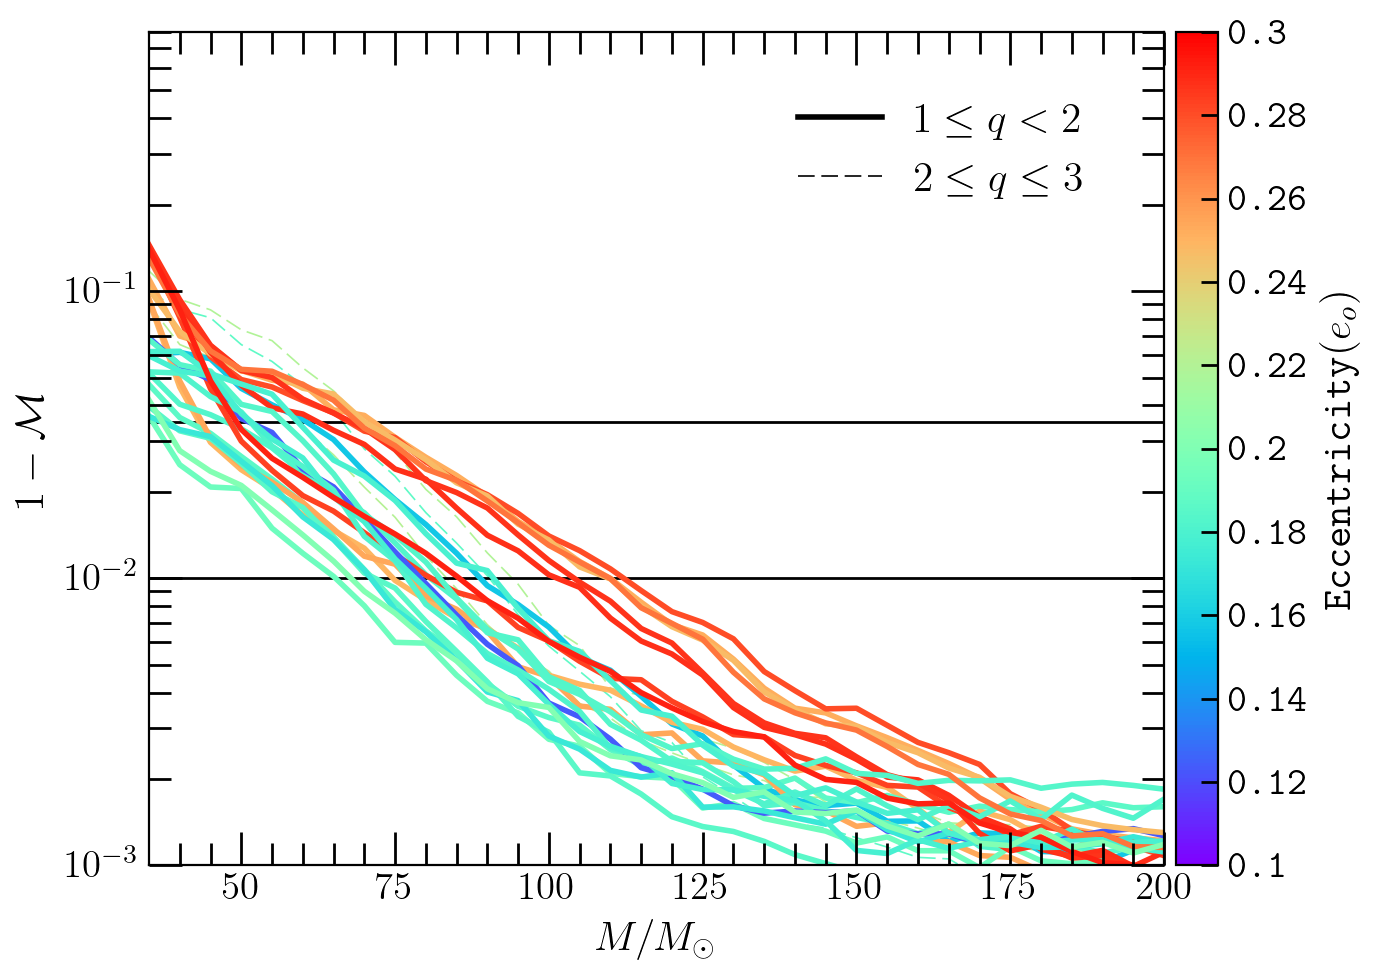

In [74]:
plt.figure(figsize=(7,5))
#N = int((0.25-0.1)/0.02) #low
#N = int((0.4-0.1)/0.02)
binl = 0.001
N = int((0.3-0.08)/binl)
cmap = plt.get_cmap('rainbow', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)
lw = [2,0.6,2.6,1.5]
lsty=['-','--',':']

plt.axhline(y = 1-0.965, color = 'k', linestyle = '-',linewidth = 1)
plt.axhline(y = 1-0.99, color = 'k', linestyle = '-',linewidth = 1)

for i in range(0,len(e_ini)):
    if q[i]<2:
        plt.plot(Mtot,1-np.array(match_Enigma[i]),linestyle=lsty[0],linewidth = lw[0],alpha=1,c=cmap(int((estr[i]-0.08)/binl)))
    else:
        plt.plot(Mtot,1-np.array(match_Enigma[i]),linestyle=lsty[1],dashes=(10,4),linewidth = lw[1],alpha=1, zorder=-1, c=cmap(int((estr[i]-0.08)/binl)))
    #elif q[i]<=2 and q[i]>1:
        #plt.plot(Mtot,1-np.array(match_Enigma[i]),linestyle=lsty[0],linewidth = lw[0],alpha=1,c=cmap(int((estr[i]-0.08)/binl)))
    #else:
        #plt.plot(Mtot,1-np.array(match_Enigma[i]),linestyle=lsty[1],dashes=(10,4),linewidth = lw[1],alpha=1,c=cmap(int((estr[i]-0.08)/binl)))

#plt.plot(Mtot,1-np.array(match0_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[0]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match1_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[1]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match2_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[2]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match3_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[3]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match4_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[4]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match5_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[5]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match6_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[6]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match7_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[7]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match8_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[8]-0.0)/binl)))

#plt.plot(Mtot,1-np.array(match9_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[9]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match10_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[10]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match11_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[11]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match12_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[12]-0.0)/binl)))




#clr2 = ['grey']
#plt.plot(Mtot,1-np.array(match0_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match1_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match2_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match3_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match4_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match5_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match6_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match7_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match8_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)

#plt.plot(Mtot,1-np.array(match9_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match10_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match11_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match12_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)



#plt.colorbar(label="Mode", ticks = [21,22,32,33,43,44,54,55], orientation="vertical")

#plt.tick_params(direction='in',length=9,color='k')

cbar = plt.colorbar(sm,pad=0.01)
tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_yticklabels(tick)
cbar.set_label(label='Eccentricity$(e_o)$',size=15)
#cbar.set_ticklabels(["22", "21", "33", "32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5, direction='in')
cbar.ax.tick_params(which="minor",width=1, length=3, direction='in')
cbar.ax.tick_params(which="major",width=1, length=6, direction='in')
plt.tick_params(axis='y', which='minor', direction='in',right=True)
plt.tick_params(axis='x',direction='in')
plt.tick_params(axis='x',direction='in',top=True)

plt.ylim(ymax=8e-1)
#plt.ylim(ymax=6.5e-1)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=1e-3)
plt.xlim(xmin=35)
plt.xlim(xmax=200)

plt.yscale('log')
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r'$1-\mathcal{M}$',fontsize=15)
plt.xlabel(r'$M/M_\odot$',fontsize=15)


#plt.grid()
#plt.legend(loc=2,ncol=2,prop={'size': 15},bbox_to_anchor=(1, 0.5))
#plt.legend(loc=2,ncol=2,prop={'size': 30})


#from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
#from matplotlib.legend_handler import HandlerBase

#class HandlerColormap(HandlerBase):
#    def __init__(self, cmap, num_stripes=8, **kw):
#        HandlerBase.__init__(self, **kw)
#        self.cmap = cmap
#        self.num_stripes = num_stripes
#    def create_artists(self, legend, orig_handle, 
#                       xdescent, ydescent, width, height, fontsize, trans):
#        stripes = []
#        for i in range(self.num_stripes):
#            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
#                          width / self.num_stripes, 
#                          height/4.5, 
#                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
#                          transform=trans)
#            stripes.append(s)
#        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
#cmaps = [plt.get_cmap('Set2', 7)]##)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)
    x_line3 = np.linspace(x, 1.5 * x, 10)
    y_line3 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    #plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line1, y_line1)
    plt.plot(x_line2, y_line2)
    plt.plot(x_line3, y_line3)


lgd1 = Line2D([0], [0], color='black', linewidth=lw[0],linestyle=lsty[0])   
lgd2 = Line2D([0], [0], color='black', linewidth=lw[1],linestyle=lsty[1],dashes=(10,4))  
#lgd3 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[2])  
    
cmap_labels = [r"$1 \leq q < 2$",r"$2 \leq q \leq 3$"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
#cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles = []
cmap_handles.append(lgd1)
cmap_handles.append(lgd2)
#cmap_handles.append(lgd3)
#handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           ncol = 1, loc=1, bbox_to_anchor=(0.96,0.96), prop={'size': 15},frameon=False)
plt.minorticks_on()
plt.tick_params(axis='x',which='minor',direction='in',top=True)   
plt.tick_params(axis='y',direction='in',right=True)
plt.tick_params(axis='y',which='minor',right=True,direction='in')
plt.tick_params(axis='x',direction='in',top=True)
plt.tight_layout()
#plt.savefig('match_20cases_flow20hz_Hyb&model_PhenomD_newallecc+2_f500M.pdf')
plt.savefig('/home/pratul/Downloads/Project/Plots_draft/ENIGMA_EOB_Match.pdf',dpi=300)
#plt.savefig('match_flow20hz_model_Feb16_ENIGMA_25pts_set2.pdf')
#plt.savefig('match_flow20hz_seobnrv4_ENIGMA_25pts_set2_v2.pdf')

/tmp/ipykernel_4734/3171797866.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick)


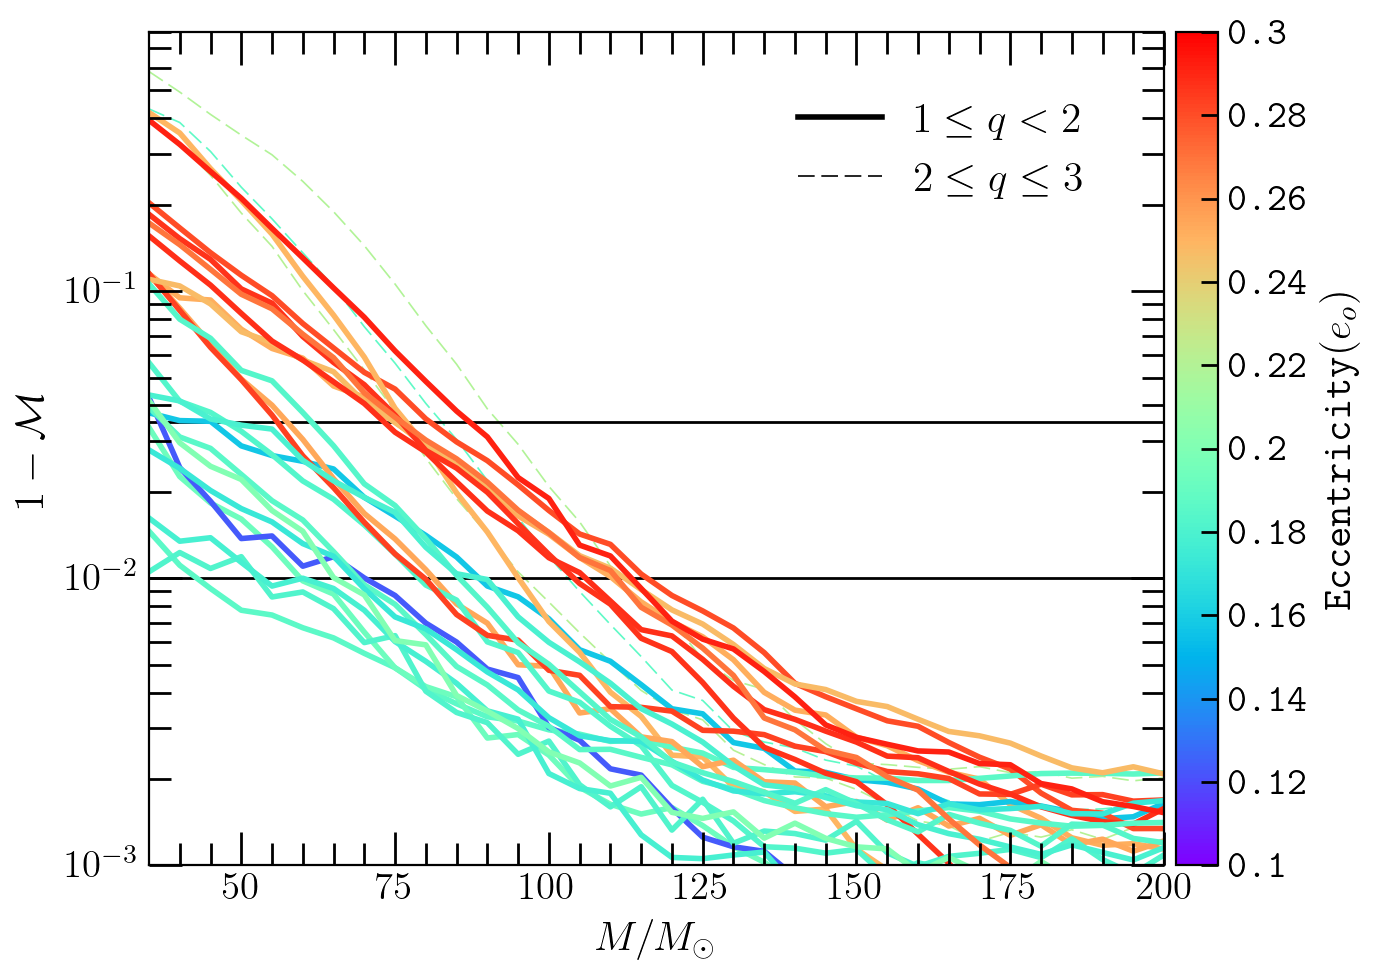

In [75]:
plt.figure(figsize=(7,5))
#N = int((0.25-0.1)/0.02) #low
#N = int((0.4-0.1)/0.02)
binl = 0.001
N = int((0.3-0.08)/binl)
cmap = plt.get_cmap('rainbow', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)
lw = [2,0.6,2.6,1.5]
lsty=['-','--',':']

plt.axhline(y = 1-0.965, color = 'k', linestyle = '-',linewidth = 1)
plt.axhline(y = 1-0.99, color = 'k', linestyle = '-',linewidth = 1)

for i in range(0,len(e_ini)):
    if q[i]<2:
        plt.plot(Mtot,1-np.array(match_Enigma1[i]),linestyle=lsty[0],linewidth = lw[0],alpha=1,c=cmap(int((estr[i]-0.08)/binl)))
    else:
        plt.plot(Mtot,1-np.array(match_Enigma1[i]),linestyle=lsty[1],dashes=(10,4),linewidth = lw[1],alpha=1, zorder=-1, c=cmap(int((estr[i]-0.08)/binl)))
    #elif q[i]<=2 and q[i]>1:
        #plt.plot(Mtot,1-np.array(match_Enigma[i]),linestyle=lsty[0],linewidth = lw[0],alpha=1,c=cmap(int((estr[i]-0.08)/binl)))
    #else:
        #plt.plot(Mtot,1-np.array(match_Enigma[i]),linestyle=lsty[1],dashes=(10,4),linewidth = lw[1],alpha=1,c=cmap(int((estr[i]-0.08)/binl)))

#plt.plot(Mtot,1-np.array(match0_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[0]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match1_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[1]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match2_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[2]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match3_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[3]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match4_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[4]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match5_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[5]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match6_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[6]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match7_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[7]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match8_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[8]-0.0)/binl)))

#plt.plot(Mtot,1-np.array(match9_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[9]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match10_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[10]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match11_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[11]-0.0)/binl)))
#plt.plot(Mtot,1-np.array(match12_EN),linestyle=lsty[0],linewidth = lw[2],alpha=0.9,c=cmap(int((estr[12]-0.0)/binl)))




#clr2 = ['grey']
#plt.plot(Mtot,1-np.array(match0_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match1_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match2_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match3_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match4_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match5_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match6_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match7_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match8_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)

#plt.plot(Mtot,1-np.array(match9_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match10_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match11_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)
#plt.plot(Mtot,1-np.array(match12_circ),linestyle=lsty[0],linewidth = lw[1],c=clr2[0],zorder=-1)


#plt.colorbar(label="Mode", ticks = [21,22,32,33,43,44,54,55], orientation="vertical")

#plt.tick_params(direction='in',length=9,color='k')

cbar = plt.colorbar(sm,pad=0.01)
tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_yticklabels(tick)
cbar.set_label(label='Eccentricity$(e_o)$',size=15)
#cbar.set_ticklabels(["22", "21", "33", "32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5, direction='in')
cbar.ax.tick_params(which="minor",width=1, length=3, direction='in')
cbar.ax.tick_params(which="major",width=1, length=6, direction='in')
plt.tick_params(axis='y', which='minor', direction='in',right=True)
plt.tick_params(axis='x',direction='in')
plt.tick_params(axis='x',direction='in',top=True)

plt.ylim(ymax=8e-1)
#plt.ylim(ymax=6.5e-1)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=1e-3)
plt.xlim(xmin=35)
plt.xlim(xmax=200)

plt.yscale('log')
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r'$1-\mathcal{M}$',fontsize=15)
plt.xlabel(r'$M/M_\odot$',fontsize=15)


#plt.grid()
#plt.legend(loc=2,ncol=2,prop={'size': 15},bbox_to_anchor=(1, 0.5))
#plt.legend(loc=2,ncol=2,prop={'size': 30})


#from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
#from matplotlib.legend_handler import HandlerBase

#class HandlerColormap(HandlerBase):
#    def __init__(self, cmap, num_stripes=8, **kw):
#        HandlerBase.__init__(self, **kw)
#        self.cmap = cmap
#        self.num_stripes = num_stripes
#    def create_artists(self, legend, orig_handle, 
#                       xdescent, ydescent, width, height, fontsize, trans):
#        stripes = []
#        for i in range(self.num_stripes):
#            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
#                          width / self.num_stripes, 
#                          height/4.5, 
#                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
#                          transform=trans)
#            stripes.append(s)
#        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
#cmaps = [plt.get_cmap('Set2', 7)]##)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)
    x_line3 = np.linspace(x, 1.5 * x, 10)
    y_line3 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    #plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line1, y_line1)
    plt.plot(x_line2, y_line2)
    plt.plot(x_line3, y_line3)


lgd1 = Line2D([0], [0], color='black', linewidth=lw[0],linestyle=lsty[0])   
lgd2 = Line2D([0], [0], color='black', linewidth=lw[1],linestyle=lsty[1],dashes=(10,4))  
#lgd3 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[2])  
    
cmap_labels = [r"$1 \leq q < 2$",r"$2 \leq q \leq 3$"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
#cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles = []
cmap_handles.append(lgd1)
cmap_handles.append(lgd2)
#cmap_handles.append(lgd3)
#handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           ncol = 1, loc=1, bbox_to_anchor=(0.96,0.96), prop={'size': 15},frameon=False)

plt.minorticks_on()
plt.tick_params(axis='x',which='minor',direction='in',top=True)   
plt.tick_params(axis='y',direction='in',right=True)
plt.tick_params(axis='y',which='minor',right=True,direction='in')
plt.tick_params(axis='x',direction='in',top=True)
plt.tight_layout()
#plt.savefig('match_20cases_flow20hz_Hyb&model_PhenomD_newallecc+2_f500M.pdf')
plt.savefig('/home/pratul/Downloads/Project/Plots_draft/ENIGMA_MODEL_Match.pdf',dpi=300)
#plt.savefig('match_flow20hz_model_Feb16_ENIGMA_25pts_set2.pdf')
#plt.savefig('match_flow20hz_seobnrv4_ENIGMA_25pts_set2_v2.pdf')

In [ ]:
print(e_ini)